In [2]:
import torch
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
t_c = torch.tensor([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]) # in celcius
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]) # in unknown unit

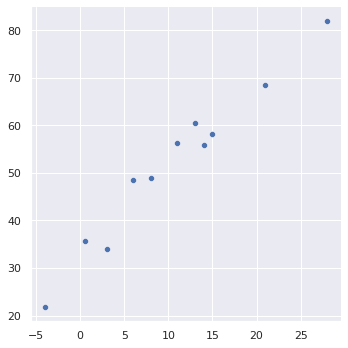

In [4]:
# We want a scatter plot. The relational plot function is more general, and uses a scatter plot as default
sns.relplot(x=t_c, y=t_u)

<AxesSubplot:>

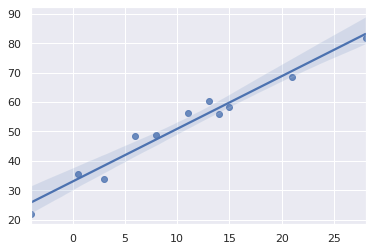

In [5]:
# plotting the regression line along with a 95% confidence interval
# for some reason, doesn't work well with tensors
sns.regplot(x=t_c.numpy(), y=t_u.numpy())

We'll assume a linear model at first.
`t_c = w * t_u + b`

analogous to
`y = mx + c`

but the slope is called the weight, and the intercept is called the bias

### My understanding of gradient descent for linear regression:
- We have ground truths (`y`) and some inputs (`x`)
- We choose a linear model to "fit" to the data - It is the parameters of this model that we want to estimate. In our case, the model is `y_pred = mx+c`
- To optimize the model parameters, we need a measure of how good the predictions are. Thus, we introduce a loss function, which tells us how bad.good we're doing. For example, here, we use mean squared loss (mean of the deviations of `y_pred` from `y`)
- We want to choose a `m` and a `c` such that the loss is minimized, ie, we reach the minima of the loss function.
- To do this we need to move in the direction of lower loss, taking smaller and smaller steps once the loss becomes small enough.
- For this, we use partial derivatives of the loss funtion with respect to `m` and `c`! The tell us the slope (rate of change) at a particular point in the loss function for a given `m` and `c`. We use that along with a "learning" rate to adjust the `m` and `c`, and repeat the process until we reach a acceptable low loss.


In [6]:
# define the model
def model(t_u, w, b):
    return t_u * w + b

def loss_fn(t_u, t_p):
    sq_diff = (t_u - t_p)**2 # this is a tensor, we need a mean to get a single number 
    return sq_diff.mean() # mean square loss


loss 2.9276463985443115 dw -9.822845458984375e-05, db 0.0006138194585219026
w 5.367083549499512 b -17.30118751525879


<AxesSubplot:>

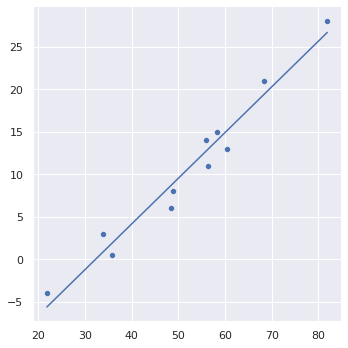

In [7]:

w = torch.ones(()) # just tensor(1.)
b = torch.zeros(())
R = 1e-2 # learning rate

t_u_normalized = t_u/10 # Have input be scaled down. Helps with model convergence.
for i in range(5000):
    predicted = model(t_u_normalized, w, b)
    loss = loss_fn(t_c, predicted)
    derivative_weight = -2*((t_u_normalized*(t_c-predicted)).mean())
    derivative_bias = -2*((t_c-predicted).mean())
    # update w and b, take step with respect to the gradient at that point
    w = w - (derivative_weight*R)
    b = b - (derivative_bias*R)

print(f"loss {loss} dw {derivative_weight}, db {derivative_bias}")
print(f"w {w} b {b}")


sns.relplot(x=t_u, y=t_c)
sns.lineplot(x=t_u, y=model(t_u_normalized, w, b)) # only model takes normalized input


## introducing autograd (pytorch specific)
- In the above example, we computed the derivatives (gradient) of a loss function with respect to the innermost parameters (`w` and `b`)
- `autograd` in pytorch can automatically compute gradients, no matter how nested.
    - the tensors remember their parent source, and can provide a chain of derivatives with respect to the input
    


In [15]:
# [w,b] tensor.
# The optional argument signals to pytorch to keep track of all the tensors that result from an operation on `params`.
params = torch.tensor([1.0, 0.0], requires_grad=True)
print(params)
print(params.grad)

tensor([1., 0.], requires_grad=True)
None


In [16]:
# the loss tensor is a result from an operation on the params tensor.
# we can now cal `.backward()` on the loss tensor. It will store the derivatives of the loss fn with respect to both parameters
# in the `.grad` attribute of the params.
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

print(f"params {params}, params_grad {params.grad}")

params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82.6000])


## ALERT !!
- The gradients are *accumulated*(SUMMED) in the `.grad` attribute.
- i.e, the gradients are *accumulated* at the leaf nodes of the computation graph pytorch creates when a computation is a result of a tensor with `require_grad=True`
- We thus have to set them to zero every time we want to zero the gradient at each iteration.
- If we dont, the new gradients will keep adding up on top of the old ones, leading to incorrect updates
- It doesnt happen automatically to be more flexible for other types of models.

In [21]:
# an example:
params = torch.tensor([1.0, 0.0], requires_grad=True)
print("Without zeroing the gradient (accumulates even though params not updated)")
for i in range(5):
    loss = loss_fn(model(t_u, *params), t_c)
    loss.backward()
    print(f"params {params}, params_grad {params.grad}")
params = torch.tensor([1.0, 0.0], requires_grad=True)
print("\nZeroing the gradient (remove the accumulation)")
for i in range(5):
    if params.grad is not None :
        params.grad.zero_() # make it zero _in place_
    loss = loss_fn(model(t_u, *params), t_c)
    loss.backward()
    print(f"params {params}, params_grad {params.grad}")   


Without zeroing the gradient (accumulates even though params not updated)
params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82.6000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([9034.5938,  165.2000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([13551.8906,   247.8000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([18069.1875,   330.4000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([22586.4844,   413.0000])

Zeroing the gradient (remove the accumulation)
params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82.6000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82.6000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82.6000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82.6000])
params tensor([1., 0.], requires_grad=True), params_grad tensor([4517.2969,   82

## defining the training loop with autograd

In [41]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1,n_epochs+1):
        # zero the accumulated gradients, we want a fresh batch
        if params.grad is not None :
            params.grad.zero_()
        predicted = model(t_u, *params)
        loss = loss_fn(predicted, t_c)
        loss.backward()

        # no_grad temporarily disables requires_grad=true.
        # This is because we just want to update the values in place,
        # and not track these changes and have it effect the gradient later down the road
        with torch.no_grad():
            # use the computed gradients to adjust the params
            # we usually don't want to do inplace updates like this, as values might be needed later.
            params -= params.grad*learning_rate

        # print out loss at every 500 epochs
        if epoch%500==0:
            print(f"Epoch {epoch} Loss {loss}")
    return params


In [42]:
t_u_normalized = t_u*0.1
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_u_normalized,
    t_c = t_c)

Epoch 500 Loss 7.860115051269531
Epoch 1000 Loss 3.828537940979004
Epoch 1500 Loss 3.092191219329834
Epoch 2000 Loss 2.957697868347168
Epoch 2500 Loss 2.933133840560913
Epoch 3000 Loss 2.9286484718322754
Epoch 3500 Loss 2.9278297424316406
Epoch 4000 Loss 2.9276793003082275
Epoch 4500 Loss 2.927651882171631
Epoch 5000 Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

^ we got the same loss and params as what we manually did!

## looking into how pytorch abstracts optimization strategies
---
### Summary of how i understood it works
- first, the gradients are calculated with `.backward()` (on a tensor that results from a computation on a tensor with `grad` enabled). Every optimizer needs these gradients to calculate the model parameter updates.
- Once the gradients are accumulated in the param tensor(remember to clear them out in the training loop), the optimizer can access them inside itself, because we pass the param tensor to it during initialization. And when we call <optimizer>`.step()`, it **updates the parameters in place** based on the optimization algorithm. In the case of gradient descent, it subtracts the gradient times the learning rate from the parameters.

In [43]:
import torch.optim as optim

In [44]:
# different optimizers at out disposal
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [50]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
# SGD is same as vanilla gradient descent, except it does it for a random subset of input samples. By default, it works like vanilla gradient descent
# params argument given to the optimizer should be an iterable of Tensors or dicts. thats why it's in a list
optimizer = optim.SGD([params], lr=learning_rate)
predicted = model(t_u, *params)
loss = loss_fn(predicted, t_c)
# accumulates gradients at leaf nodes of comp graph (at params, via `params.grad`)
loss.backward() 
# now, the optimizer has access to the gradients in param, it can update the params "in place" 
# we don't have to do that weird `with torch.zero_grad()` thing, it's handled internally and in a better way.
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

> in a training loop, have to zero the gradients for the params in the optimizer

In [51]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1,n_epochs+1):
        # zero the accumulated gradients, we want a fresh batch
        optimizer.zero_grad()

        predicted = model(t_u, *params)
        loss = loss_fn(predicted, t_c)
        loss.backward() # calculate gradients
        optimizer.step() # update the parameters

        # print out loss at every 500 epochs
        if epoch%500==0:
            print(f"Epoch {epoch} Loss {loss}")
    return params

In [53]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
t_u_normalized = t_u*0.1
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_u_normalized,
    t_c = t_c)

Epoch 500 Loss 7.860119819641113
Epoch 1000 Loss 3.828537940979004
Epoch 1500 Loss 3.092191219329834
Epoch 2000 Loss 2.957697868347168
Epoch 2500 Loss 2.933133840560913
Epoch 3000 Loss 2.9286484718322754
Epoch 3500 Loss 2.9278297424316406
Epoch 4000 Loss 2.9276793003082275
Epoch 4500 Loss 2.927651882171631
Epoch 5000 Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

In [56]:
# We can also try out others! such as adam, which has an adaptive learning rate, not as sensitive to learning rate and normalization, and so on.
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500 Loss 7.612900257110596
Epoch 1000 Loss 3.086700439453125
Epoch 1500 Loss 2.928579092025757
Epoch 2000 Loss 2.9276442527770996
Epoch 2500 Loss 2.927645206451416
Epoch 3000 Loss 2.9276459217071533
Epoch 3500 Loss 2.927644968032837
Epoch 4000 Loss 2.927645683288574
Epoch 4500 Loss 2.9276463985443115
Epoch 5000 Loss 2.927645206451416


tensor([  0.5368, -17.3048], requires_grad=True)